# Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Задача - Построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак
- `Price` — цена (евро)

In [44]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

In [45]:
!pip install lightgbm

In [46]:
data = pd.read_csv('autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [47]:
data_copy = data

In [48]:
data[data['NumberOfPictures']!=0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


## Заполнение пропусков

Рассмотрим наши данные, которые мы имеем и их зависимость с целевым признаком(если она присутствует):
 - Vehicle Type - имеет строковый тип, чем лучше тип автомобиля тем выше цена.
  - Gearbox - наличие автоматической коробки передач повышает цену автомобиля.
  - Power - прямая пропорциональная зависимость с целевым признаком
  - Kilometr - чем больше проеханных автомобилем километров , тем ниже цена

In [49]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [51]:
print('Vehical: ',data['VehicleType'].isna().sum()/data.shape[0])
print('Gearbox: ',data['Gearbox'].isna().sum()/data.shape[0])
print('FuelType: ',data['FuelType'].isna().sum()/data.shape[0])
print('Model: ',data['Model'].isna().sum()/data.shape[0])
print('Repaired: ',data['Repaired'].isna().sum()/data.shape[0])

Vehical:  0.1057936783409384
Gearbox:  0.055967085156997366
FuelType:  0.09282696849893755
Model:  0.055605879746817584
Repaired:  0.20079070121822168


In [52]:
np.sort(data['RegistrationYear'])

array([1000, 1000, 1000, ..., 9999, 9999, 9999], dtype=int64)

Рассмотрев данные, сразу можно заметить
 - столбец NumberOfPictures, который на всех объектах равен 0. Его сразу можно удалить так как он не повлияет на обучение модели.
  - Признак Repared имеет наибольшее кол-во пропусков, также этот признак может иметь значение yes/no, поэтому можно заменить пропуски на значения no.
  - Vechicle Type можно заполнить по марке автомобиля.

  - FuelType можно заполнить по марке автомобиля
  - PostalCode - почтовый индекс никак не повлияет на целевой признак, поэтому его необходимо убрать
  - Остальные пропуска находятся в признаках, которые имеют строчное значение, и их нельзя заменить на какое то определенное,например тип кузова, так как данные слишком важны, и такое заполнение пропусков может только помешать обучению.

In [53]:
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"], axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [54]:
data['Repaired'] = data['Repaired'].fillna('no')
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,no
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [55]:
vehicle_type_pivot_table = data.pivot_table(index='VehicleType',
                                                          columns='Brand',
                                                          values='Price',
                                                          aggfunc='count')
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,7.0,159.0,436.0,1262.0,50.0,27.0,36.0,833.0,...,614.0,231.0,1.0,202.0,17.0,28.0,447.0,NaN,9536.0,NaN
convertible,180.0,1627.0,3266.0,17.0,238.0,114.0,NaN,1.0,17.0,520.0,...,NaN,4.0,1132.0,330.0,1.0,36.0,65.0,37.0,2963.0,75.0
coupe,229.0,1499.0,3809.0,90.0,48.0,152.0,NaN,8.0,NaN,177.0,...,87.0,10.0,341.0,230.0,8.0,8.0,232.0,4.0,1784.0,69.0
other,15.0,110.0,242.0,46.0,10.0,121.0,6.0,5.0,12.0,184.0,...,74.0,26.0,9.0,256.0,6.0,14.0,21.0,7.0,760.0,5.0
sedan,945.0,10965.0,17585.0,231.0,295.0,714.0,103.0,107.0,47.0,904.0,...,1781.0,911.0,29.0,486.0,168.0,183.0,895.0,230.0,19738.0,643.0
small,239.0,1571.0,448.0,582.0,12.0,1590.0,223.0,268.0,527.0,5308.0,...,3119.0,1124.0,3267.0,261.0,119.0,985.0,1588.0,58.0,18531.0,7.0
suv,1.0,180.0,818.0,384.0,23.0,36.0,215.0,1.0,49.0,24.0,...,4.0,173.0,NaN,429.0,62.0,749.0,445.0,1.0,1331.0,221.0
wagon,457.0,11081.0,7929.0,110.0,244.0,629.0,252.0,47.0,17.0,455.0,...,399.0,2709.0,9.0,139.0,300.0,89.0,572.0,79.0,12660.0,1989.0


In [56]:
print(vehicle_type_pivot_table.columns)
vehicle_type_pivot_table['audi'].idxmax()

Index(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen',
       'volvo'],
      dtype='object', name='Brand')


'wagon'

In [57]:
def fill_by_brand(row,col):
    if row[col] == np.nan or pd.isnull(row[col]) and not pd.isnull(row['Brand']):
        return vehicle_type_pivot_table[row['Brand']].idxmax()
    return row[col]

data['VehicleType'] = data.apply(fill_by_brand,args=['VehicleType'], axis=1)
data['FuelType'] = data.apply(fill_by_brand,args=['FuelType'], axis=1)

In [58]:
data.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired                 0
dtype: int64

## Аномальные значения

Для начала рассмотрим цену автомоблей , естественно большую 0. Рассмотрим квантили 85 и 5, чтобы проанализировать до какого значения находится 85% нашей выборки и до какого 5%.

<AxesSubplot:>

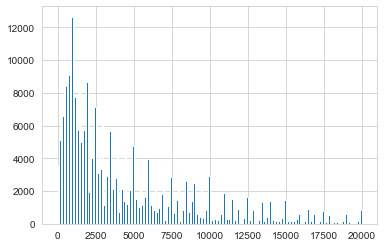

In [59]:
(data[data['Price']>0]['Price']).hist(bins=200)

In [60]:
np.quantile(data['Price'], q=[0.85,0.05])

array([9000.,  200.])

Поставим 1250 евро как минимальную цену автомобиля,а максимальную 10700

In [61]:
data = data[(data['Price']<=9000) & (data['Price']>=200)]
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,sedan,2005,NaN,0,NaN,20000,1,sedan,sonstige_autos,no
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no


In [62]:
data['Price'].min()
np.sort(data['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1928, 1930, 1931, 1932, 1934, 1935, 1936, 1937,
       1938, 1942, 1943, 1944, 1945, 1946, 1948, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2066, 2200, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000,
       4100, 4500, 4800, 5000, 5300, 5555, 5900, 5911, 6000, 7000, 7100,
       8200, 8500, 8888, 9000, 9450, 9999], dtype=int64)

In [63]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1
data= data[data['RegistrationYear']<=2019]
data["RegistrationYear"] = data["RegistrationYear"].where(data["RegistrationYear"] > 1940, 1940)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9212\3218000122.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["RegistrationYear"] = data["RegistrationYear"].where(data["RegistrationYear"] > 1940, 1940)


In [64]:
np.sort(data['RegistrationYear'].unique())

array([1940, 1942, 1943, 1944, 1945, 1946, 1948, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

In [65]:
np.sort(data['Power'].unique())
data[data['Power']==4]['Brand']

16523     sonstige_autos
33068         volkswagen
49038         volkswagen
69207     sonstige_autos
88466            citroen
95318     sonstige_autos
109202              ford
120776              opel
121536    sonstige_autos
139190    sonstige_autos
145108    sonstige_autos
184412    sonstige_autos
197424    sonstige_autos
203355    sonstige_autos
209629    sonstige_autos
215586    sonstige_autos
217018    sonstige_autos
218619    sonstige_autos
221866    sonstige_autos
225005    sonstige_autos
233590    sonstige_autos
239456    sonstige_autos
241917    sonstige_autos
245004    sonstige_autos
275464              audi
304450    sonstige_autos
336690    sonstige_autos
337076    sonstige_autos
339663    sonstige_autos
340724    sonstige_autos
Name: Brand, dtype: object

Можно заметить, что в данных минимальная цена автомобиля - 0 евро. Это аномальное значение, так как такого не может быть, поэтому мы оставляем машины у которых цена больше 1250 евро а маскимальную 10700 , проанализировав квантили. Также в данных присутствуют года, которые еще не наступили, их точно убираем. Минимальное возмонжное значение можности автомобиля ставим 4.

## Подготовка данных для обучения моделей

In [66]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['Brand'] = data['Brand'].fillna('unknown')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9212\1497213560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['VehicleType'] = data['VehicleType'].fillna('unknown')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9212\1497213560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gearbox'] = data['Gearbox'].fillna('unknown')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9212\1497213560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [67]:
features = data.drop('Price',axis=1)
target = data['Price']

In [68]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.2,random_state=12345)

In [69]:
features_train_ohe = features_train.reset_index(drop=True)
features_test_ohe = features_test.reset_index(drop=True)

In [70]:
cat_features = ['VehicleType', 'Model', 'FuelType', 'Gearbox', 'Repaired', 'RegistrationMonth', 'Brand']
num_features = ['Power', 'Kilometer', 'RegistrationYear']

## Обучение моделей

### LightGBM

Подбор гиперпараметров

In [71]:
%%time
light_column_transformer = ColumnTransformer([('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)], remainder='passthrough')
light_column_transformer.fit(features_train)

CPU times: total: 531 ms
Wall time: 542 ms


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['VehicleType', 'Model', 'FuelType', 'Gearbox',
                                  'Repaired', 'RegistrationMonth', 'Brand'])])

In [72]:
%%time
lgb_train = lgb.Dataset(light_column_transformer.transform(features_train), target_train)
lgb_test = lgb.Dataset(light_column_transformer.transform(features_test), target_test, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                  lgb_train,
                  num_boost_round=1000,
                  valid_sets=[lgb_train, lgb_test],
                  verbose_eval=100)

C:\Users\ASUS\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 227224, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3010.761557
[100]	training's l2: 1.21884e+06	valid_1's l2: 1.24686e+06
[200]	training's l2: 1.1248e+06	valid_1's l2: 1.17201e+06
[300]	training's l2: 1.07271e+06	valid_1's l2: 1.13781e+06
[LightGBM] [Warning] N

In [73]:
%%time
print("LightGBM RMSE:",(mean_squared_error(target_train,light.predict(light_column_transformer.transform(features_train)),squared=False)))

LightGBM RMSE: 951.990810966475
CPU times: total: 19.2 s
Wall time: 6.96 s


In [74]:
# regressor = LGBMRegressor()
# hyperparams = [{'num_leaves':[31, 100, 200],
#                 'learning_rate':[0.1, 0.3, 0.5],
#                 'random_state':[19072020]}]
#
# print('# Tuning hyper-parameters for root_mean_squared_error')
# print()
# clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
# clf.fit(features_train, target_train)
# print("Best parameters set found on development set:")
# print()
# print(clf.best_params_)
# print()
# print("Grid scores on development set:")
# print()

### CatBoost

In [77]:
# %%time
# catboost = CatBoostRegressor(loss_function='RMSE')
# parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
# catboost_grid = catboost.grid_search(parameters_cat,
#                                       Pool(features_train, target_train, cat_features=["VehicleType","Gearbox","Model","FuelType",
#                                                                                     "Brand","Repaired"]),cv=3,verbose=True,plot=False)

In [78]:
%%time
model_catboost = CatBoostRegressor(depth=5,
                                     learning_rate=0.2, loss_function='RMSE')
model_catboost.fit(features_train, target_train, cat_features=["VehicleType","Gearbox",
                                                               "Model","FuelType",
                                                               "Brand","Repaired"])


0:	learn: 2114.4532371	total: 502ms	remaining: 8m 21s
1:	learn: 1944.0945690	total: 990ms	remaining: 8m 13s
2:	learn: 1807.3225158	total: 1.46s	remaining: 8m 3s
3:	learn: 1705.7476718	total: 1.79s	remaining: 7m 26s
4:	learn: 1624.1895658	total: 2.18s	remaining: 7m 13s
5:	learn: 1552.3824716	total: 2.71s	remaining: 7m 29s
6:	learn: 1502.0710136	total: 3.11s	remaining: 7m 20s
7:	learn: 1456.1407753	total: 3.35s	remaining: 6m 55s
8:	learn: 1422.3950831	total: 3.73s	remaining: 6m 51s
9:	learn: 1390.5244615	total: 4.04s	remaining: 6m 39s
10:	learn: 1361.6573625	total: 4.23s	remaining: 6m 20s
11:	learn: 1342.3348927	total: 4.56s	remaining: 6m 15s
12:	learn: 1324.7627806	total: 4.9s	remaining: 6m 12s
13:	learn: 1307.7144503	total: 5.1s	remaining: 5m 59s
14:	learn: 1296.8444911	total: 5.43s	remaining: 5m 56s
15:	learn: 1284.4597660	total: 5.61s	remaining: 5m 44s
16:	learn: 1276.5612464	total: 5.92s	remaining: 5m 42s
17:	learn: 1268.2285608	total: 6.19s	remaining: 5m 37s
18:	learn: 1262.4021155

In [79]:
%%time
predictions_cat = model_catboost.predict(features_train)
print('RMSE:', mean_squared_error(y_true=target_train, y_pred=predictions_cat, squared=False))

RMSE: 1020.1605653107846
CPU times: total: 4.06 s
Wall time: 2.01 s


### LinearRegression

In [80]:
lin_column_transformer = ColumnTransformer([('num', StandardScaler(), num_features), ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)])
lin_pipe = Pipeline([('ct', lin_column_transformer), ('model', LinearRegression())])

In [81]:
%%time

lin_pipe.fit(features_train, target_train)
scores = cross_val_score(lin_pipe, features_train, target_train, cv=5, verbose=True, n_jobs=-1, scoring='neg_root_mean_squared_error')
final_score = sum(scores) / len(scores)

print('Средняя оценка качества модели:', final_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


Средняя оценка качества модели: -1709.9945931214265
CPU times: total: 17.4 s
Wall time: 37.3 s


In [82]:
%%time

print('RMSE:', mean_squared_error(y_true=target_train, y_pred=lin_pipe.predict(features_train), squared=False))

RMSE: 1705.8295258696883
CPU times: total: 734 ms
Wall time: 741 ms


### RandomForest

In [83]:
forest_pipe = Pipeline([('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), ('model', RandomForestRegressor(random_state=12345, n_jobs=-1))])

In [84]:
# params = {'model__max_depth': range (10, 41, 10), 'model__n_estimators': range(1, 11, 2)}
# grid = GridSearchCV(forest_pipe, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=10)
# grid.fit(features_train, target_train)
# print('Лучшие параметры:', grid.best_params_)
# print('Лучший счет:', grid.best_score_)

Лучшие параметры: {'model__max_depth': 20, 'model__n_estimators': 9}
Лучший счет: -1095.5217856510317

In [85]:
forest_pipe = Pipeline([('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), ('model', RandomForestRegressor(max_depth=20, n_estimators=9, random_state=12345, n_jobs=-1))])

In [86]:
%%time
forest_pipe.fit(features_train, target_train)

CPU times: total: 11.2 s
Wall time: 4.44 s


Pipeline(steps=[('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=9, n_jobs=-1,
                                       random_state=12345))])

In [87]:
%%time
predictions_forest = forest_pipe.predict(features_train)

CPU times: total: 1.52 s
Wall time: 855 ms


In [88]:
print('RMSE:', mean_squared_error(y_true=target_train, y_pred=predictions_forest, squared=False))

RMSE: 674.3528844263813


# Вывод

В данном проекте проделанную работу можно разделить на нексолько частей. Первая часть - обработка данных. Мы убрали лишние данные, заполнили пропуски, убрали аномальные значения. Далее, самая важная часть проекта - обучение моделей. Обучались 4 модели - `LightGBM`,`LinearRegression`,`CatBoost`,`RandomForest`. По результатам сравнивания метрики RMSE выяснилось, что лучше всего обучилась модель RandomForest(674), бустинги(LightGBM и CatBoost) показали похожие результаты(951 и 1020), LightGBM оказался чуть лучше. И хуже всего обучилась линейная регрессия(1705). Если оценивать обучение по критериям, которые важны заказчику, будем расставлять места от 1 до 3 места.
- качество предсказания
    - LightGBM - 2,
    - LinearRegression - 4,
    - CatBoost - 3
    - RandomForest - 1;
- время обучения модели
    - LightGBM - 1,
    - LinearRegression - 3,
    - CatBoost - 4,
    - RandomForest - 2;
- время предсказания модели -
    - LightGBM - 4,
    - LinearRegression - 1,
    - CatBoost - 3,
    - RandomForest - 2.
Итого, у нас получилось, что лучше всего нам подходит RandomForest, на втором месте LightGBM.